In [1]:
%load_ext autoreload

In [2]:
import os
import pickle as pk
from itertools import tee
from math import ceil
import statistics

import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
plt.ioff()
import yaml

In [3]:
ROOT_PATH = os.path.join(os.path.pardir, "logs", "CPAN_vs_GIN")

## Rename results

In [4]:
class Renamer:
    def __init__(self):
        self.required_fields = ["data_ratio", "encoder_dataset", "classifier_dataset", "encoder_epochs", "mod"]

    def rename_result(self, path):
        conf_file = os.path.join(path, "configs.yml")
        try:
            configs = yaml.load(open(conf_file, "r"), Loader=yaml.FullLoader)
        except FileNotFoundError:
            return
        new_name = ""
        for key, value in configs.items():
            if not key in self.required_fields: continue
            if isinstance(value, list):
                value = value[0]
            if new_name == "":
                new_name += str(value)
            else:
                new_name += "_" + str(value)
        counter = 1
        while 1:
            try:
                os.rename(path, os.path.join(os.path.dirname(path), new_name))
                break
            except FileExistsError:
                counter += 1
                new_name += "_" + str(value) + "_" + str(counter)
    
    def rename_results(self, path):
        results = os.scandir(path)
        for res in results:
            if not res.is_dir():
                continue
            self.rename_result(res.path)

In [5]:
rn = Renamer()

In [6]:
for folder in ["GIN", "CPAN"]:
    for date in os.scandir(os.path.join(ROOT_PATH, folder)):
        for task in os.scandir(date.path):
            rn.rename_results(task.path)

## Compare different mode of CPAN

In [3]:
class Analyzer:
    
    def __init__(self, root, metric="validating_AP_AUC", metric_fname="classifier_metrics.pk"):
        self.root = root
        self.metric = metric
        self.metric_fname = metric_fname
        self._header_written = False
        
    @property
    def groups(self):
        try:
            return self._groups
        except AttributeError:
            self._groups = self.find_groups()
            return self._groups
        
    def find_groups(self):
        dirs = os.scandir(self.root)
        groups = set()
        for dir_ in dirs:
            name = os.path.basename(dir_.path)
            base_name = "_".join(name.split("_")[:-1])
            groups.add(base_name)
        return sorted(list(groups))
    
    def _number_of_rows(self, nplots, ncols):
        return int(ceil(nplots / ncols))

    def plot_results(self, ncols=4, figsize=[16, 12], ylim=[0, 1]):
        groups = self.groups
        modes = ["origin", "additive", "scaled"]
        nr = self._number_of_rows(len(groups), ncols)
        fig, axes = plt.subplots(ncols=ncols, nrows=nr, figsize=figsize)
        fig.tight_layout(pad=3.0)
        for grp, axe in zip(groups, axes.flatten()[:len(groups)]):
            for mod in modes:
                with open(os.path.join(self.root, f"{grp}_{mod}", self.metric_fname), "rb") as f:
                    metric = pk.load(f)[self.metric]
                label_name = f"{self.metric}_{mod}"
                axe.plot(list(range(len(metric))), metric, label=label_name)
            axe.set_ylim(ylim)
            axe.legend()
            axe.set_title(grp)
            axe.grid(axis="y")
        return fig, axes
    
    def _write_header(self, outf, metrics):
        if self._header_written:
            return
        outf.write("group_mode,")
        outf.write(",".join([key for key in metrics.keys() if "loss" not in key]))
        outf.write("\n")
        self._header_written = True
        
    def _find_best(self, metric):
        return statistics.mean(sorted(metric)[-5:])
    
    def _analysis_metrics(self, metrics, group, mode):
        outf = open(os.path.join(self.root, "statistics.csv"), "a")
        self._write_header(outf, metrics)
        outf.write(f"{group}_{mode}")
        for key, metric in metrics.items():
            if "loss" in key:
                continue
            best_avg = self._find_best(metric)
            outf.write(f",{best_avg}")
        outf.write("\n")
        outf.close()
    
    def results_statistics(self, mode="scaled"):
        groups = self.groups
        for grp in groups:
            with open(os.path.join(self.root, f"{grp}_{mode}", self.metric_fname), "rb") as f:
                metrics = pk.load(f)
            self._analysis_metrics(metrics, grp, mode)

<IPython.core.display.Javascript object>


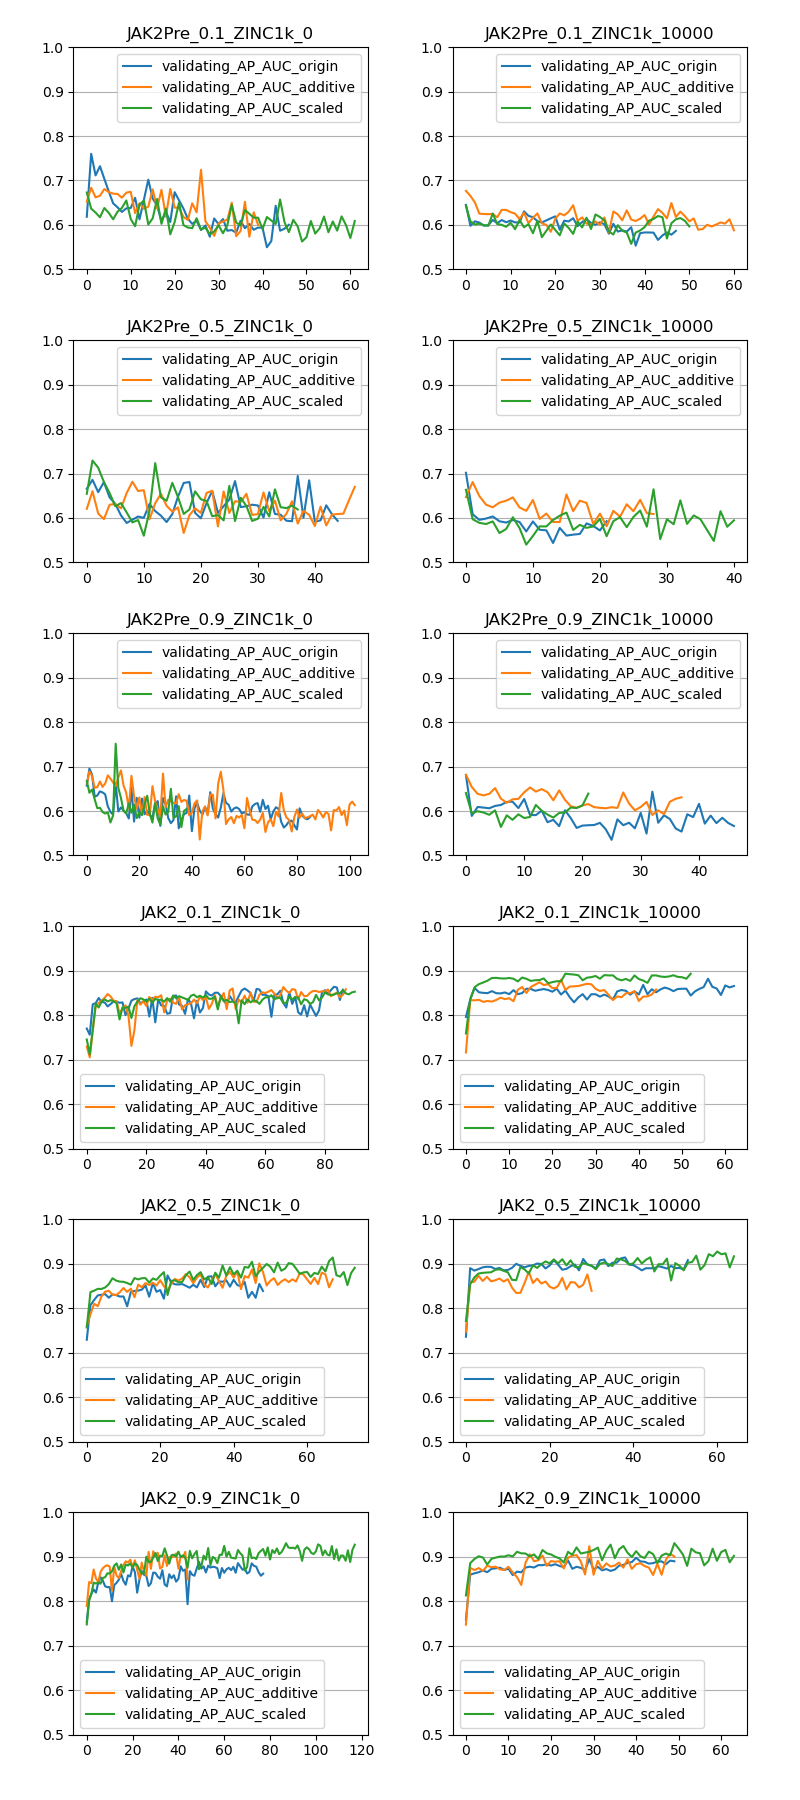

In [49]:
ana = Analyzer(os.path.join(ROOT_PATH, "CPAN", "20200623_232501", "ZINC1k_JAK2"))
ana.results_statistics()
fig, _ = ana.plot_results(ncols=2, figsize=[8, 18], ylim=[0.5, 1])
fig.savefig(os.path.join(ROOT_PATH, "CPAN_ZINC1k_JAK2.png"), dpi=300)
fig.show()

<IPython.core.display.Javascript object>


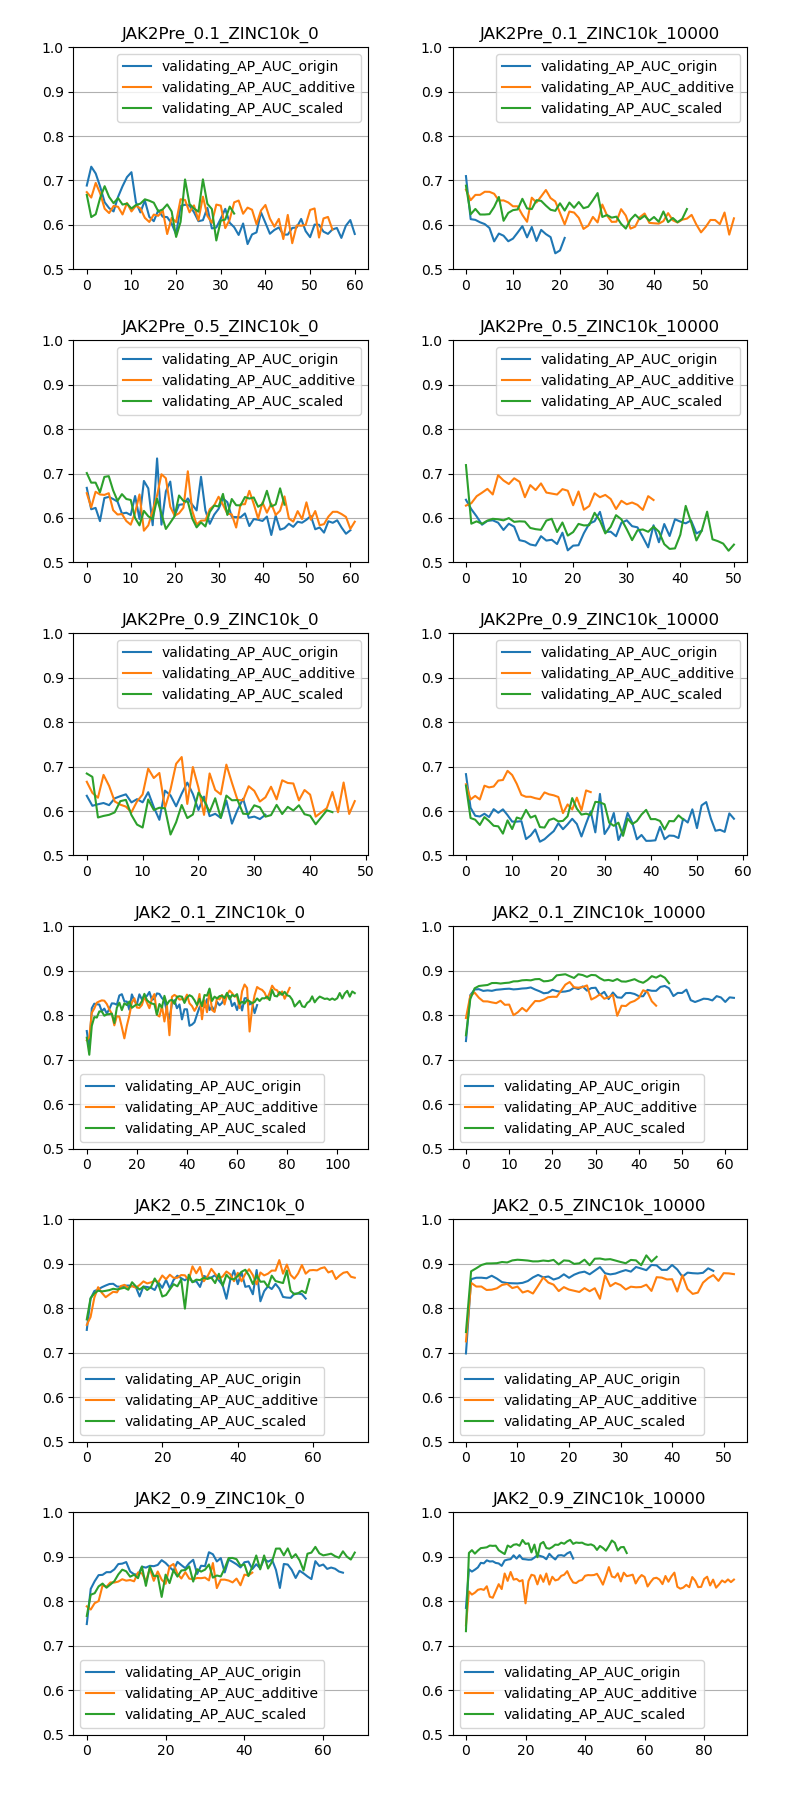

In [50]:
ana = Analyzer(os.path.join(ROOT_PATH, "CPAN", "20200623_232501", "ZINC10k_JAK2"))
ana.results_statistics()
fig2, _ = ana.plot_results(ncols=2, figsize=[8, 18], ylim=[0.5, 1])
fig2.savefig(os.path.join(ROOT_PATH, "CPAN_ZINC10k_JAK2.png"), dpi=300)
fig2.show()

<IPython.core.display.Javascript object>


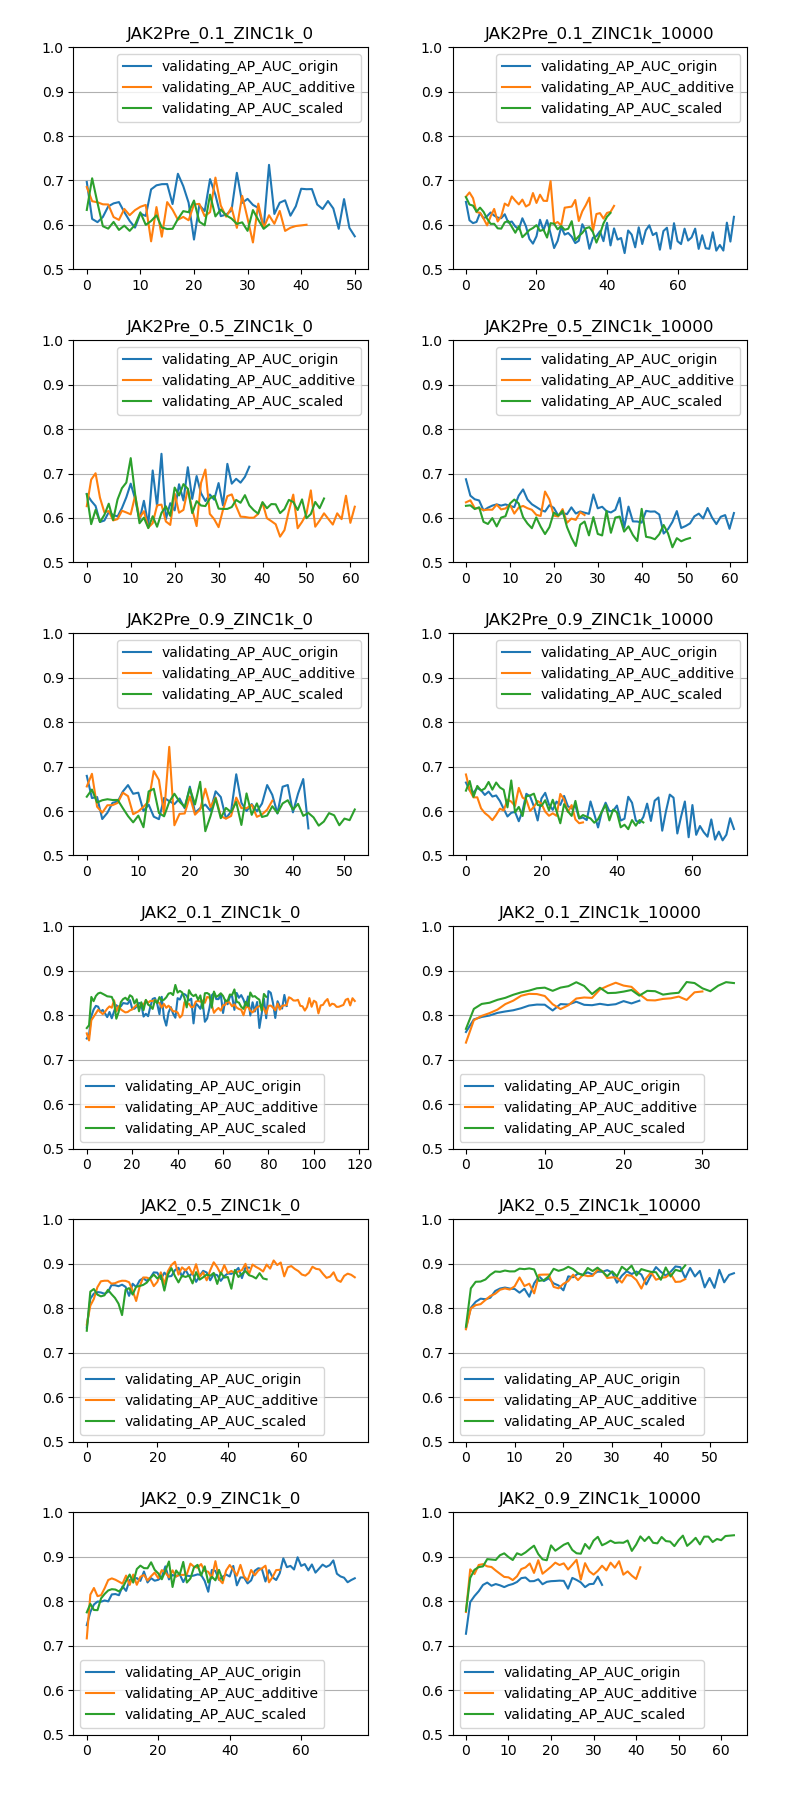

In [51]:
ana = Analyzer(os.path.join(ROOT_PATH, "CPAN", "20200623_232501", "ZINC1k"))
ana.results_statistics()
fig3, _ = ana.plot_results(ncols=2, figsize=[8, 18], ylim=[0.5, 1])
fig3.savefig(os.path.join(ROOT_PATH, "CPAN_ZINC1k.png"), dpi=300)
fig3.show()

<IPython.core.display.Javascript object>


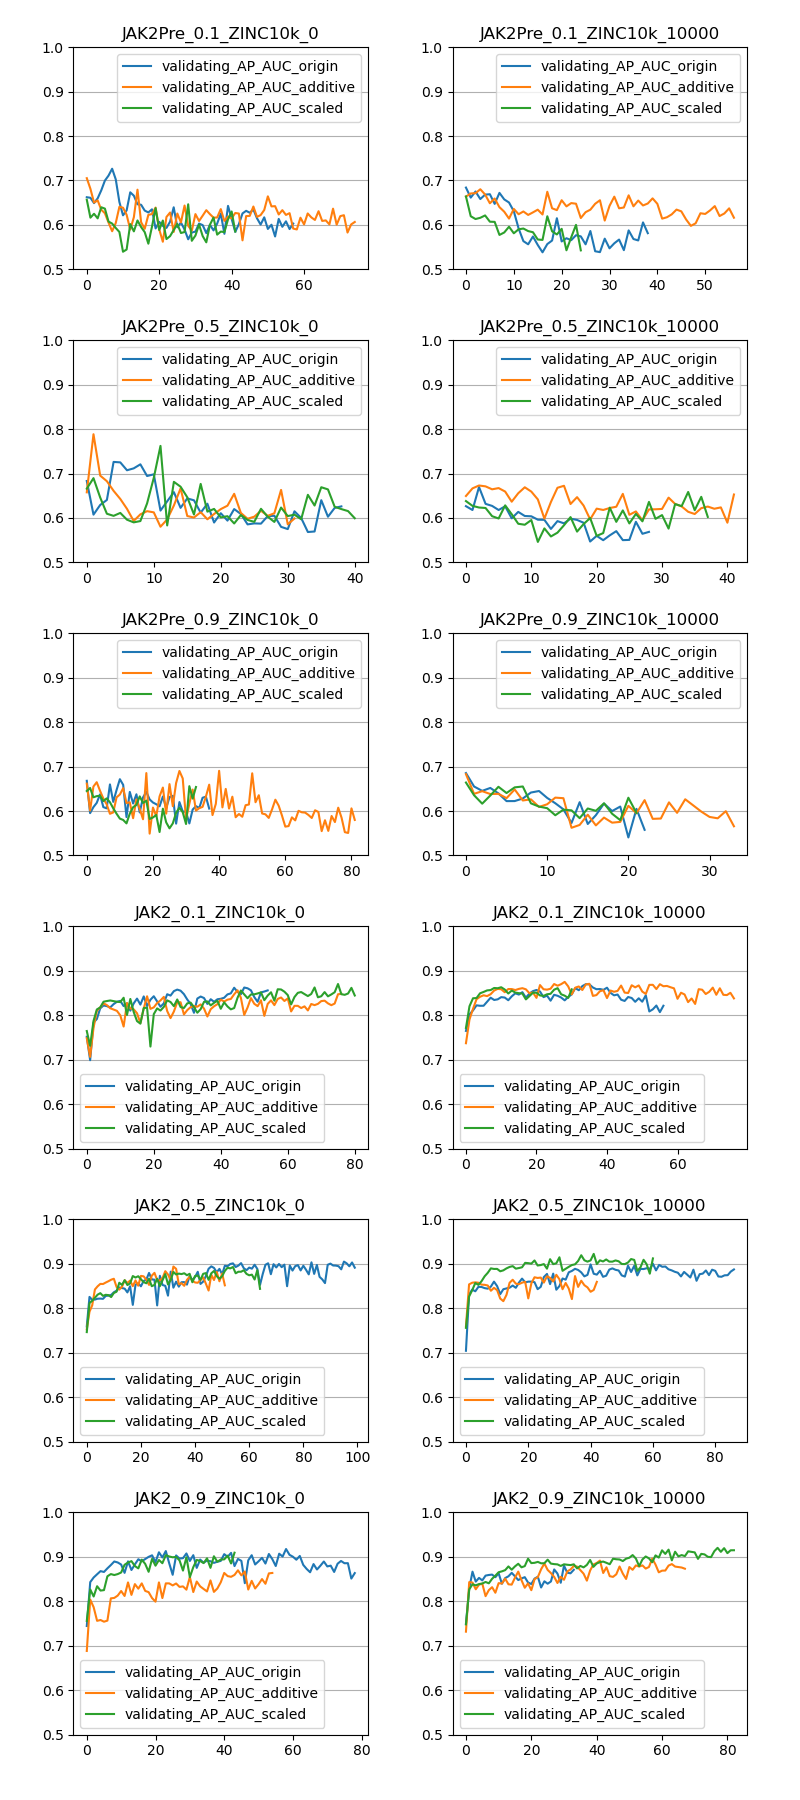

In [52]:
ana = Analyzer(os.path.join(ROOT_PATH, "CPAN", "20200623_232501", "ZINC10k"))
ana.results_statistics()
fig4, _ = ana.plot_results(ncols=2, figsize=[8, 18], ylim=[0.5, 1])
fig.savefig(os.path.join(ROOT_PATH, "CPAN_ZINC10k.png"), dpi=300)
fig4.show()

#### Statistics for GIN results

In [53]:
for task in ["ZINC1k", "ZINC10k", "ZINC1k_JAK2", "ZINC10k_JAK2"]:
    ana = Analyzer(os.path.join(ROOT_PATH, "GIN", "20200623_232501", task))
    ana.results_statistics()

## Compare CPAN with GIN

In [12]:
TIME_STAMP = "20200623_232501"
ROOT = os.path.join(os.path.pardir, "logs", "CPAN_vs_GIN")
METRICS_FILE = "classifier_metrics.pk"

In [13]:
class Comparer:
    
    def __init__(self, root, time_stamp, task_name, metric="validating_AP_AUC"):
        self.root = root
        self.time_stamp = time_stamp
        self.task_name = task_name
        self.cpan_path = os.path.join(self.root, "CPAN", time_stamp, task_name)
        self.gin_path = os.path.join(self.root, "GIN", time_stamp, task_name)
        self.metrics_file = METRICS_FILE
        self.metric = metric
        
    def compare(self, ncols=4, figsize=[16, 12], ylim=[0, 1]):
        cpan_results = os.scandir(self.cpan_path)
        self.cpan_results = list()
        self.gin_results = list()
        for res in cpan_results:
            if not "scaled" in res.name:
                continue
            self.cpan_results.append(res.path)
            self.gin_results.append(os.path.join(self.gin_path, res.name))
        return self._plot_results(ncols, figsize, ylim)
        
    def _number_of_rows(self, nplots, ncols):
        return int(ceil(nplots / ncols))

    def _plot_results(self, ncols, figsize, ylim):
        nr = self._number_of_rows(len(self.cpan_results), ncols)
        fig, axes = plt.subplots(ncols=ncols, nrows=nr, figsize=figsize)
        fig.tight_layout(pad=3.0)
        tasks = zip(self.cpan_results, self.gin_results, axes.flatten()[:len(self.cpan_results)])
        for cpan_r, gin_r, axe in tasks:
            with open(os.path.join(cpan_r, self.metrics_file), "rb") as f:
                cpan_metric = pk.load(f)[self.metric]
            with open(os.path.join(gin_r, self.metrics_file), "rb") as f:
                gin_metric = pk.load(f)[self.metric]
            axe.plot(list(range(len(cpan_metric))), cpan_metric, label=f"CPAN_{self.metric}")
            axe.plot(list(range(len(gin_metric))), gin_metric, label=f"GIN_{self.metric}")
            axe.set_ylim(ylim)
            axe.legend()
            axe.set_title(os.path.basename(cpan_r))
            axe.grid(axis="y")
        return fig, axes

<IPython.core.display.Javascript object>


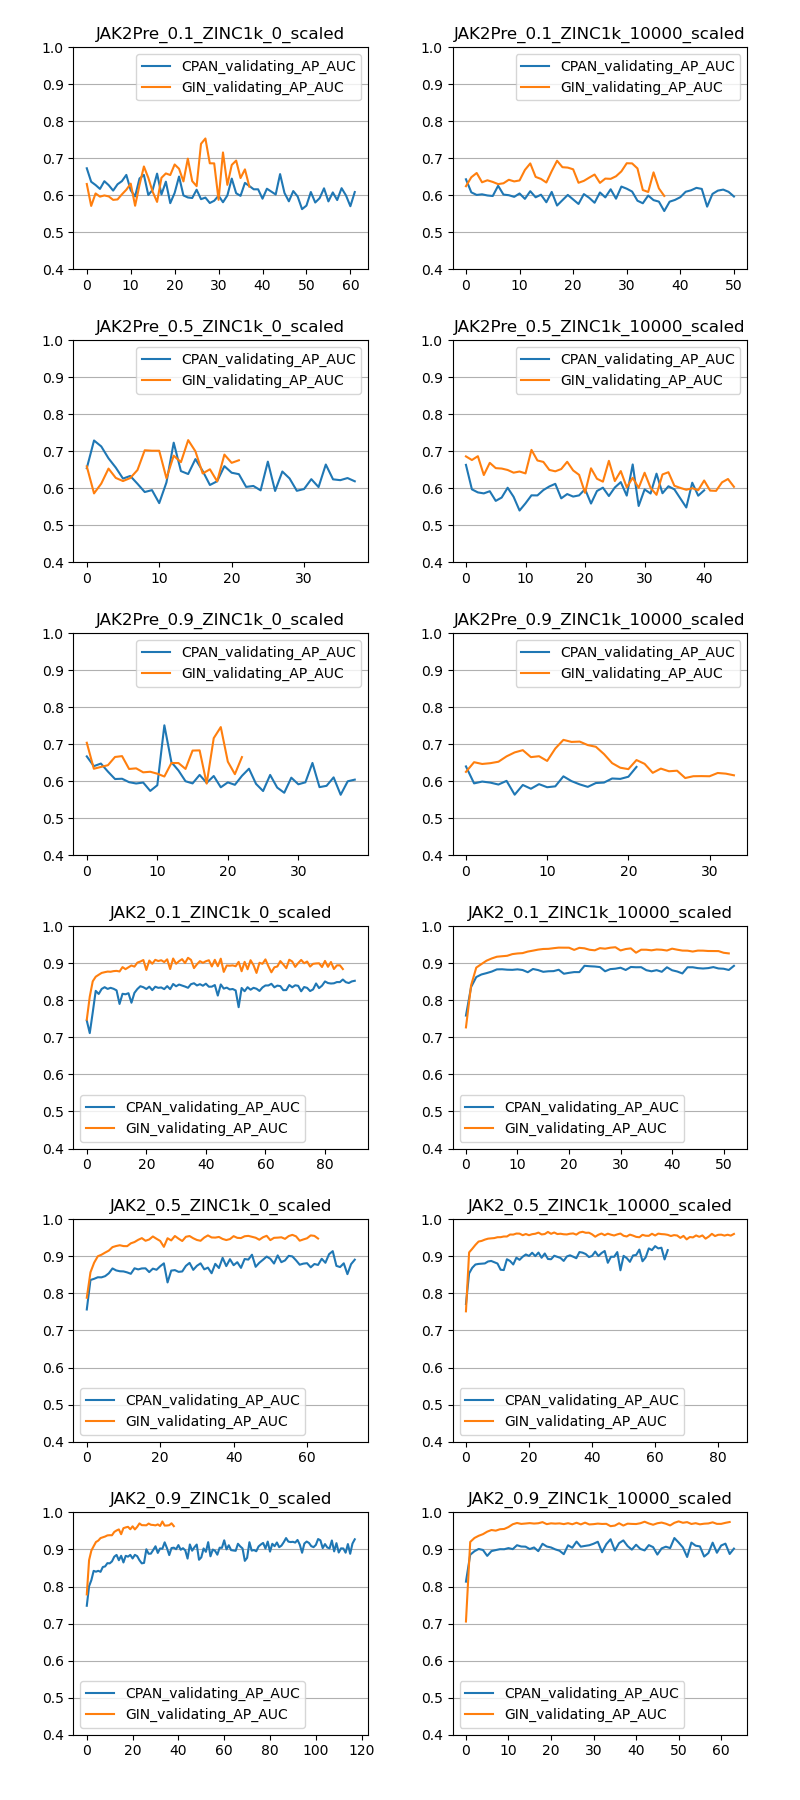

In [24]:
com = Comparer(ROOT, TIME_STAMP, "ZINC1k_JAK2")
fig, _ = com.compare(ncols=2, figsize=[8, 18], ylim=[0.4, 1])
fig.savefig(os.path.join(ROOT_PATH, "CPANvsGIN_ZINC1k_JAK2.png"), dpi=300)
fig.show()

<IPython.core.display.Javascript object>


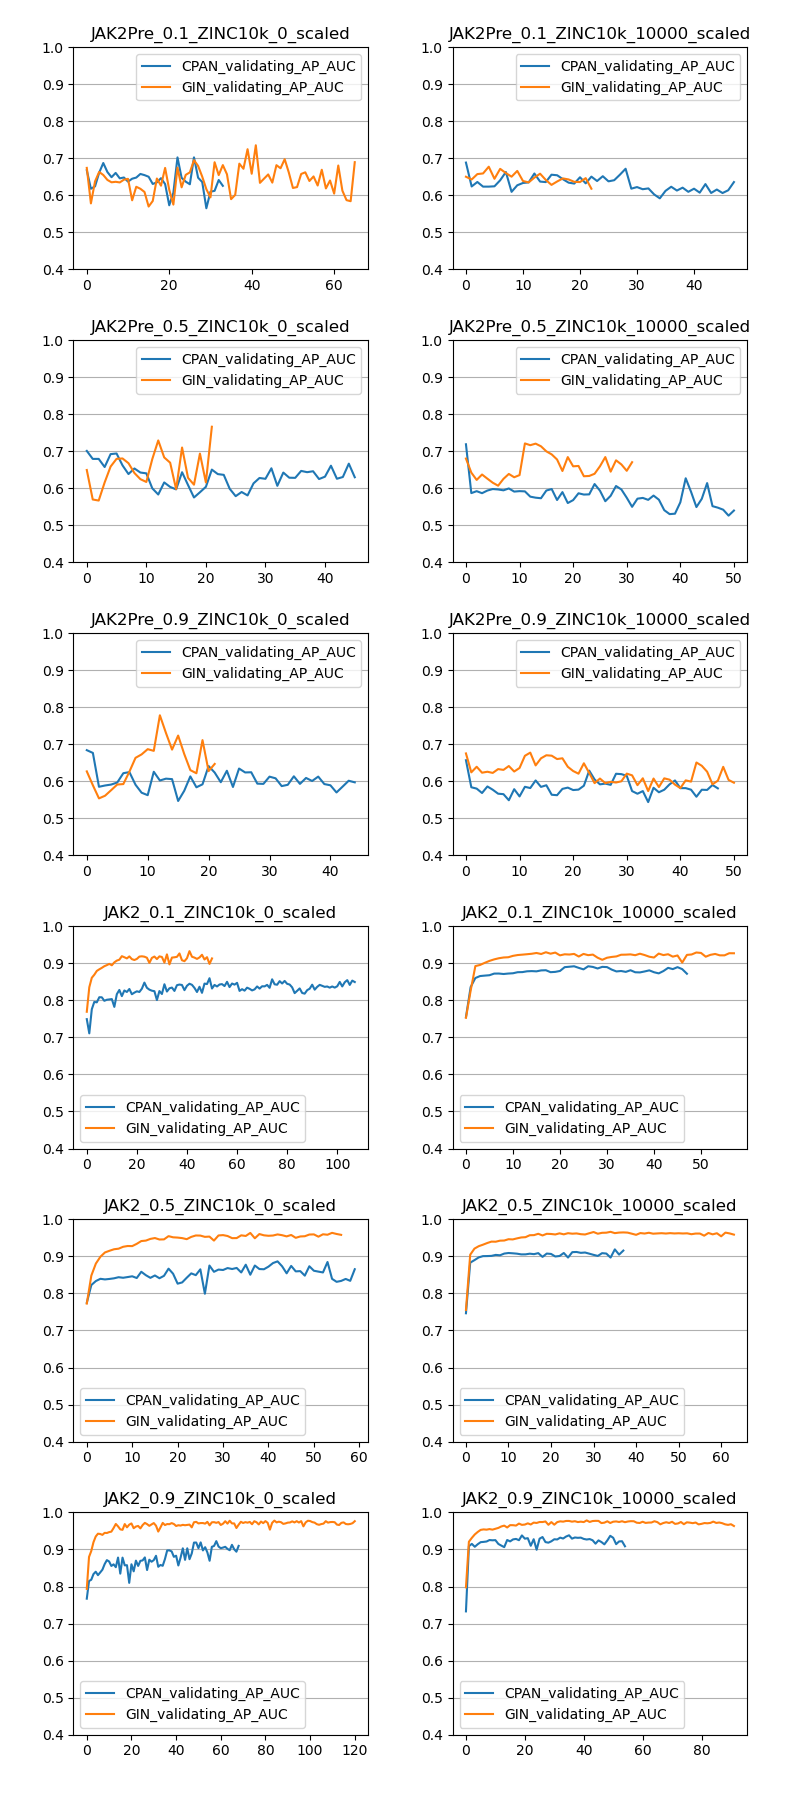

In [25]:
com = Comparer(ROOT, TIME_STAMP, "ZINC10k_JAK2")
fig, _ = com.compare(ncols=2, figsize=[8, 18], ylim=[0.4, 1])
fig.savefig(os.path.join(ROOT_PATH, "CPANvsGIN_ZINC10k_JAK2.png"), dpi=300)
fig.show()

<IPython.core.display.Javascript object>


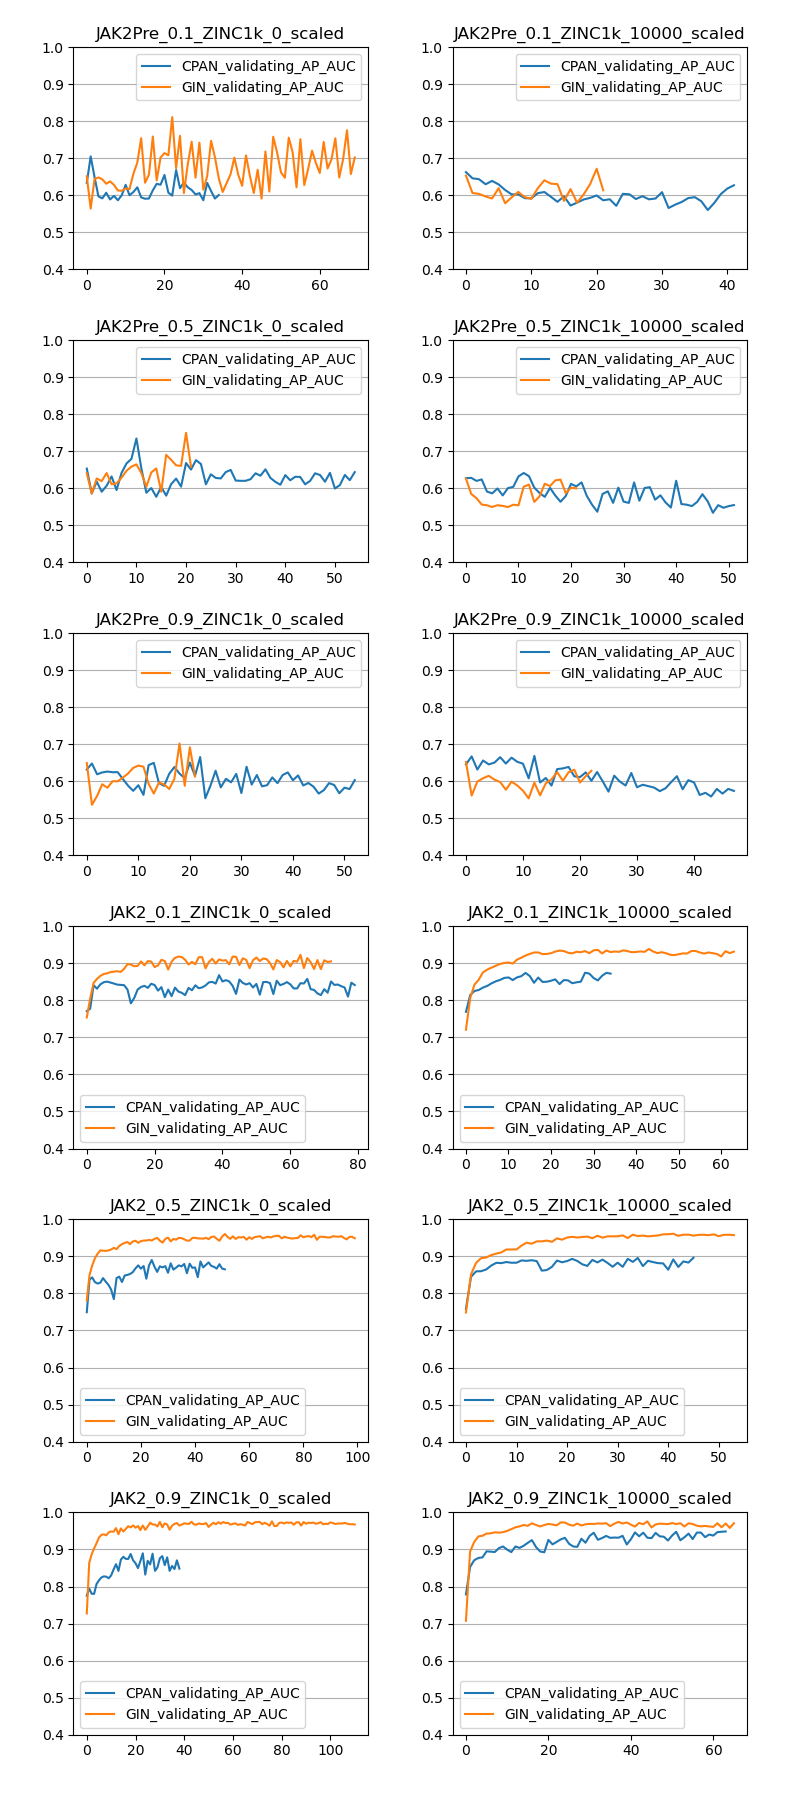

In [26]:
com = Comparer(ROOT, TIME_STAMP, "ZINC1k")
fig, _ = com.compare(ncols=2, figsize=[8, 18], ylim=[0.4, 1])
fig.savefig(os.path.join(ROOT_PATH, "CPANvsGIN_ZINC1k.png"), dpi=300)
fig.show()

<IPython.core.display.Javascript object>


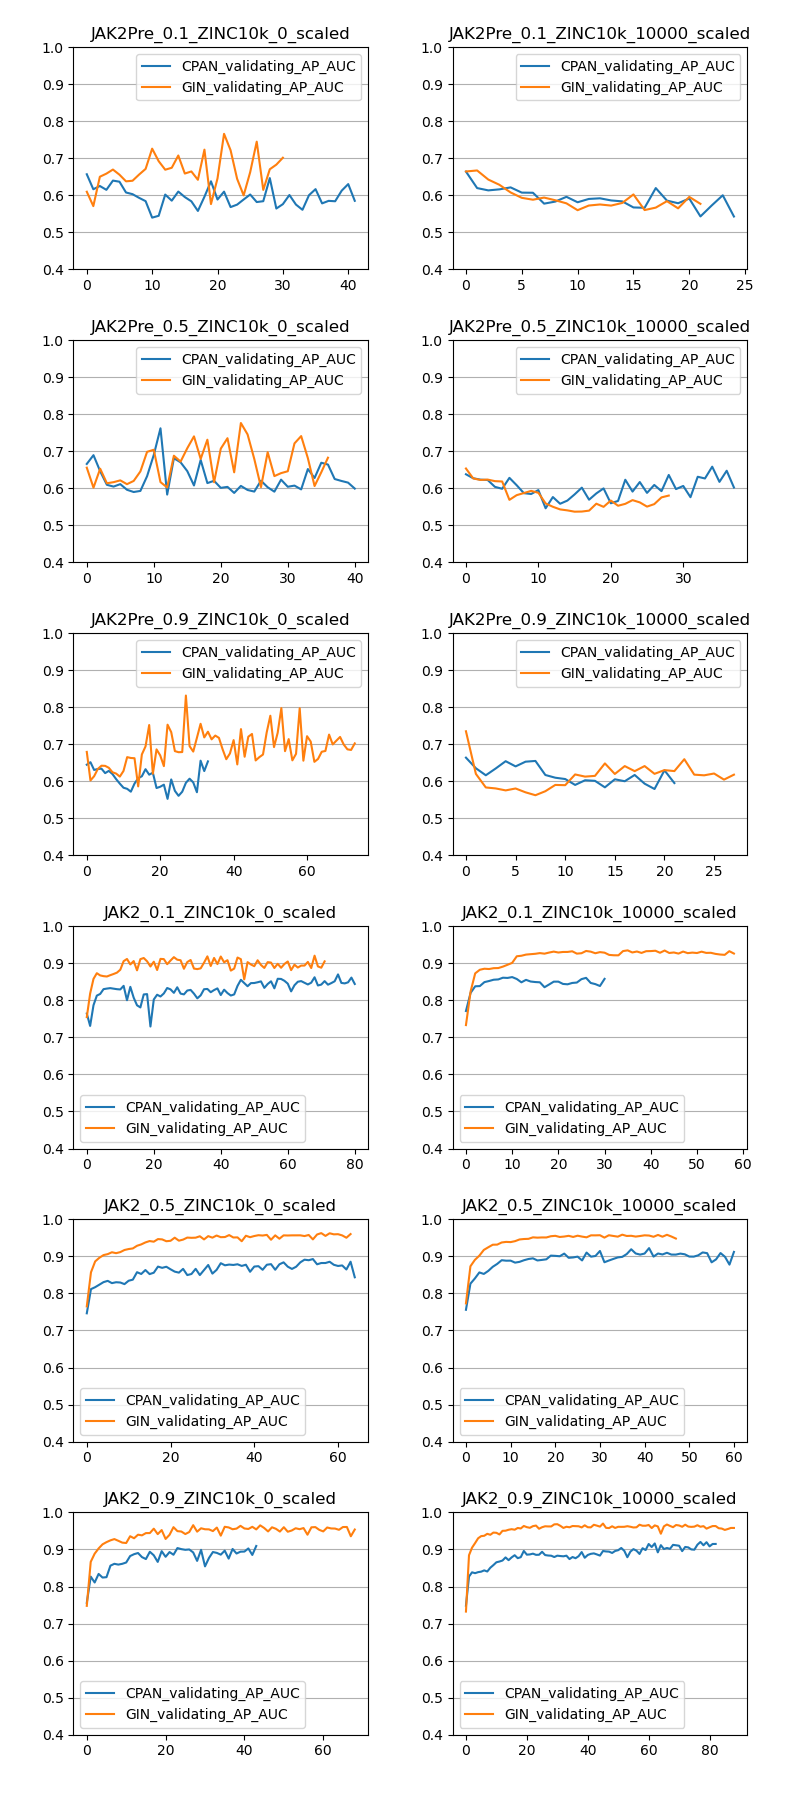

In [27]:
com = Comparer(ROOT, TIME_STAMP, "ZINC10k")
fig, _ = com.compare(ncols=2, figsize=[8, 18], ylim=[0.4, 1])
fig.savefig(os.path.join(ROOT_PATH, "CPANvsGIN_ZINC10k.png"), dpi=300)
fig.show()